# Введение в нейронные сети
<br/>
## Эпизод 2: Многослойный персептрон и CNTK
<br/>
Дмитрий Сошников

dmitri@soshnikov.com

Данная презентация представляет собой введение в современные нейронные сети на основе Microsoft Cognitive Toolkit (CNTK). Идея однодневного мастер-класса основана на Neural Network Workshop в Microsoft Research Cambridge. Материал и фрагменты кода частично взяты из презентаций [Katja Hoffmann](https://www.microsoft.com/en-us/research/people/kahofman/), [Matthew Johnson](https://www.microsoft.com/en-us/research/people/matjoh/) и [Ryoto Tomioka](https://www.microsoft.com/en-us/research/people/ryoto/) из Microsoft Research Cambridge. [NeuroWorkshop](http://github.com/shwars/NeuroWorkshop) подготовлен [Дмитрием Сошниковым](http://blog.soshnikov.com), Microsoft Russia.

## Обучение с учителем

**Дано:**
  * Обучающая выборка $\mathbf{X} \in \mathbb{R}^{n 	imes k}$
    * $n$ - размер выборки
    * $x_i$ представлено вектором свойств размерности $k$
  * Известные значения целевой функции $\mathbf{Y}$ ($y_i$ соответствует вектору свойств $x_i$)
    * $\mathbf{Y} \in \mathbb{R}^{n 	imes 1}$ (задачи регрессии)
    * $\mathbf{Y} \in C^{n 	imes 1}$, где $y_i \in C$ (задачи классификации на $|C|$ классов)


## Задача

**Дано:**
  * Обучающая выборка $\mathbf{X} \in \mathbb{R}^{n 	imes k}$
  * Входные значение целевой функции $\mathbf{Y}$

**Необходимо построить:**
  * Функцию $f : \mathbf{X}\rightarrow \mathbf{Y}$ который _точно предсказывает_ значение целевой функции на новом наборе входных данных $\mathbf{X}_{new}$


In [1]:
%matplotlib nbagg
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
import cntk
from cntk import Trainer
from cntk.device import cpu, set_default_device
from cntk.learners import sgd
from cntk.ops import *


In [2]:
# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(0)
import random

## Пример
Рассмотрим пример двухмерной задачи классификации на 2 класса. Примером такой задачи может быть классификация опухоли на 2 типа - доброкачественная и злокачественная, в зависимости от её размера и возраста.


In [3]:
n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.3)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Разбиваем на обучающую и тестовые выборки
# В реальной жизни обучающая - 80% данных
train_x, valid_x, test_x = np.split(X, [ n//8, n*8//10])
train_labels, valid_labels, test_labels = np.split(Y, [n//8, n*8//10])

In [4]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

<IPython.core.display.Javascript object>


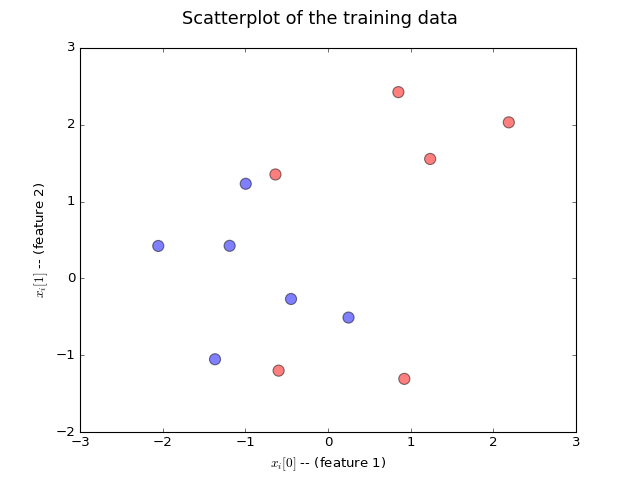

In [5]:
plot_dataset('Scatterplot of the training data', train_x, train_labels)

## Подход

  * Задаём функцию потерь (loss function) $\mathcal{L}$
  * Определяем модель $f_{\theta}$ с параметрами $\theta$
  * Подстраиваем $\theta$ для минимизации $\mathcal{L_{\theta}}$ на обучающей выборке
$	heta = \mathrm{argmin}_\theta \mathcal{L_\theta}(X,Y)$
  * Проверяем качество модели на тестовой выборке

Результат: $f_{\theta}$, которая делает предсказания на новых данных: $\hat{Y} = f_{\theta}(X_{new})$

## Функции потерь

* Определяют (формализуют) цель обучения, т.е. фразу _"точно предсказать"_
* Выбор обусловлен требуемыми свойствами (непрерывность, дифференцируемость)

**Часто используемые функции для регрессии**

Абсолютная ошибка: $\mathcal{L}_{abs}(\theta) = \sum_{i=1}^n |y_i - f_{\theta}(x_i)|$

Среднеквадратичная ошибка: $\mathcal{L}_{sq}(\theta) = \sum_{i=1}^n (y_i - f_{\theta}(x_i))^2$


In [6]:
# helper function for plotting various loss functions
def plot_loss_functions(suptitle, functions, ylabels, xlabel):
    fig, ax = pylab.subplots(1,len(functions), figsize=(9, 3))
    pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle)
    for i, fun in enumerate(functions):
        ax[i].set_xlabel(xlabel)
        if len(ylabels) > i:
            ax[i].set_ylabel(ylabels[i])
        ax[i].plot(x, fun)
    pylab.show()

<IPython.core.display.Javascript object>


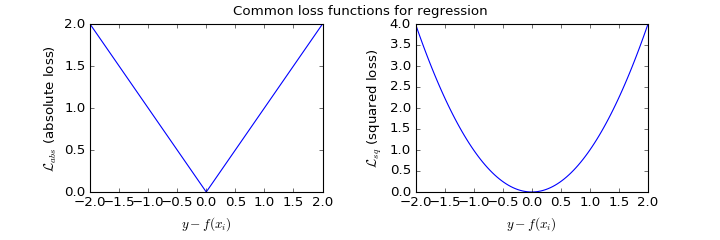

In [7]:
x = np.linspace(-2, 2, 101)
plot_loss_functions(
    suptitle = 'Common loss functions for regression',
    functions = [np.abs(x), np.power(x, 2)],
    ylabels   = ['$\mathcal{L}_{abs}}$ (absolute loss)',
                 '$\mathcal{L}_{sq}$ (squared loss)'],
    xlabel    = '$y - f(x_i)$')

## Функции ошибки для классификации

**0-1 loss**

Предполагается решающая функция вида $\hat{y} = \mathrm{sign}(f_{\theta}(x))$:

$\mathcal{L}_{0-1}(\theta) = \sum_{i=1}^n l_i \quad  l_i = \begin{cases}
         0 & y_i f_{\theta}(x) > 0 \\
         1 & в\ противном\ случае
       \end{cases} \\
$

**логистическая функция ошибки**

$\mathcal{L}_{log}(\theta) = \sum_{i=1}^n\frac{1}{\log(2)} \log(1 + e^{-y_i f_{\theta}(x)})$

In [8]:
# define and vectorize zero-one loss
def zero_one(d):
    if d < 0:
        return 1
    return 0

def logistic_loss(fx):
    # assumes y == 1
    y = 1
    return 1 / np.log(2) * np.log(1 + np.exp(-y * fx))

zero_one_v = np.vectorize(zero_one)

<IPython.core.display.Javascript object>


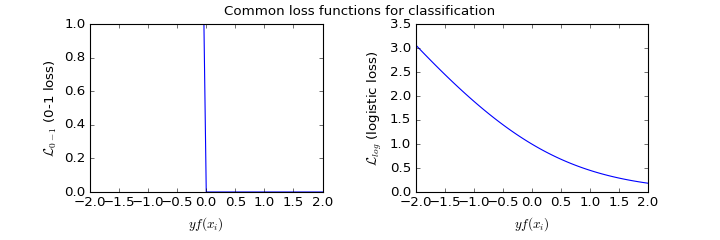

In [9]:
plot_loss_functions(suptitle = 'Common loss functions for classification',
                   functions = [zero_one_v(x), logistic_loss(x)],
                   ylabels    = ['$\mathcal{L}_{0-1}}$ (0-1 loss)',
                                 '$\mathcal{L}_{log}$ (logistic loss)'],
                   xlabel     = '$y f(x_i)$')


## Строим нейросеть
Рассмотрим решение нашей задачи при помощи простейшей однослойной нейросети такого вида:
<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/NeuroArch.PNG" width="50%"/>

При этом модель будет описываться как
$$
f_\theta(x) = W\times x + b
$$
где параметры $$\theta = <W,b>$$

### Cross-Entropy Loss

* Повсеместно применяется в глубоком обучении
* Основная идея:
    - трактуем выход модели как распределение вероятностей появления того или иного класса
    - минимизируем вероятность неправильной классификации


## Переходим к вероятностям
Расширяем нейросетевую модель с помощью функции **softmax**: $\sigma(\mathbf{z}_c) = \frac{e^{z_c}}{\sum_{j \in J} e^{z_j}}$ для  $c \in 1 .. |C|$

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/NeuroArch-softmax.PNG" width="50%">

Можем рассматривать $\sigma(\mathbf{z})$ как распределение вероятности на классах $C$: $q = \sigma(\mathbf{z}_c) = \hat{p}(c | x)$


## Ещё один взгляд на архитектуру сети

![Архитектура нейросети](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/Cross-Entropy-Loss.PNG)


## Cross-Entropy Loss

Два подхода к пониманию Cross-Entropy Loss:

  * Разница между двумя распределениями вероятностей. Энтропия $p$ + KL-расстояние между $q$ и $p$:
$\begin{align} H(p, q) = & ~\color{red}{H(p)} + \color{blue}{D_{KL}(p||q)} \\
    = & ~\color{red}{-\sum_{c \in C} p(c) \log p(c)} + \color{blue}{\sum_{c \in C} p(c) \log\frac{p(c)}{q(c)}} \\
    = & ~-\sum_{c \in C} p(c) \log q(c)
\end{align}$
  * Цена ошибки, которую мы платим за неправильную классификацию, т.е. $-\log p_y$, где $y$ - правильный класс

In [10]:
def plot_cross_ent():
    p = np.linspace(0.01, 0.99, 101) # estimated probability p(y|x)
    cross_ent_v = np.vectorize(cross_ent)
    f3, ax = pylab.subplots(1,1, figsize=(8, 3))
    l1, = pylab.plot(p, cross_ent_v(p, 1), 'r--')
    l2, = pylab.plot(p, cross_ent_v(p, 0), 'r-')
    pylab.legend([l1, l2], ['$y = 1$', '$y = 0$'], loc = 'upper center', ncol = 2)
    pylab.xlabel('$\hat{p}(y|x)$', size=18)
    pylab.ylabel('$\mathcal{L}_{CE}$', size=18)
    pylab.show()

<IPython.core.display.Javascript object>


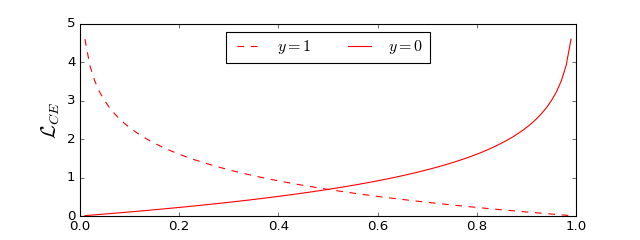

In [11]:
def cross_ent(prediction, ground_truth):
    t = 1 if ground_truth > 0.5 else 0
    return -t * np.log(prediction) - (1 - t) * np.log(1 - prediction)
plot_cross_ent()

## Задача минимизации
Описав нейронную сеть как модель $f_\theta$ и функцию ошибки $\mathcal{L}(Y,f_\theta(X))$, можем рассмотреть $\mathcal{L}$ как функцию $\theta$ на всем множестве обучающей выборки $\mathcal{L}(\theta) = \mathcal{L}(Y,f_\theta(X))$

В этом случае задача обучения сети будет формулироваться как задача минимизации $\mathcal{L}$ по $\theta$:
$$
\theta = \mathrm{argmin}_{\theta} \mathcal{L}(Y,f_\theta(X))
$$

Минимизацию можно осуществлять разными методами, например, стохастическим градиентным спуском (stochastic gradient descent, SGD)

## Реализация нейронных сетей

 * Вручную
 * С использованием готовых фреймворков
     - Tensorflow
     - Caffee
     - Teano
     - Chainer
     - [Microsoft Cognitive Toolkit](http://cntk.ai)

## Процесс обучения нейронной сети

  * Определяем архитектуру сети, опысывая её конфигурацию в виде формулы над тензорами
  * Задаём алгоритм обучения, параметры обучения - получаем объект `Trainer`
  * Определяем, откуда будут браться данные
  * Предъявляем данные алгоритму обучения, который подстраивает параметры модели
  * Пользуемся моделью, вычисляя её на требуемых $x\in\mathbf{X}_{new}$

In [12]:
input_dim=2
output_dim=2
features = input_variable(input_dim, np.float32)
label = input_variable(output_dim, np.float32)
W = parameter(shape=(input_dim, output_dim))
b = parameter(shape=(output_dim))
z = times(features,W)+b
loss = cntk.cross_entropy_with_softmax(z, label)
eval_error = cntk.classification_error(z, label)

#pp=cntk.logging.ProgressPrinter()

learning_rate = 0.02
learner = sgd(z.parameters, lr=cntk.learning_rate_schedule(learning_rate,cntk.UnitType.minibatch))
trainer = Trainer(z, (loss, eval_error), [learner])

## Вычислительный граф

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/ComputeGraph.PNG" width="600px"/>


In [13]:
def convert(labels):
    xlab = [1-x for x in labels]
    return np.vstack([labels,xlab]).transpose().astype(np.float32).copy()

## Обучение сети

  * Для обучения сети необходимо предъявлять ей примеры, считать ошибку и подстраивать коэффициенты
  * В соответствии с принципом градиентного спуска, необходимо расчитывать изменение коэффициентов в соответствии с градиентом функции $\nabla f_\theta$
  * Итерация обучения выглядит так:
 $$\begin{align}\def\L{\mathcal{L}}
 W^{i+1}&=W^i-\eta\frac{\partial\L}{\partial W}\cr
 b^{i+1}&=b^i-\eta\frac{\partial\L}{\partial b}
 \end{align}
 $$

## Обратное распространение ошибки

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/ComputeGraph.PNG" width="300px" align="left"/>

$$\def\zz#1#2{\frac{\partial#1}{\partial#2}}
\begin{align}
\zz{\L}{W} =& \zz{\L}{p}\zz{p}{z}\zz{z}{W}\cr
\zz{\L}{b} =& \zz{\L}{p}\zz{p}{z}\zz{z}{b}
\end{align}
$$

## Обратное распространение ошибки

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/ComputeGraphGrad.PNG" width="400px" align="right"/>

   * Не повторяем одинаковые вычисления
   * Вычисляем ошибку на каждом узле начиная с конца
   * Обратное распространение ошибки
   * Все вычисления фреймворк берёт на себя

## Тензоры

> *Тензоры - это такие многомерные матрицы*

 * `W = parameter(shape=(2,2))`
 * `x = input_variable(2)`
 * `z = times(x,W)` - умножаем тензор $1\times2$ на тензор $2\times2$, получаем $1\times2$

Для вычисления используем `eval` с подстановкой переменных:
 * `z.eval({ x : [1.0,2.0] })`
 * `z.eval({ x : [[1.0,2.0],[2.0,1.0]] })` - можем производить вычисления в матричной форме (построчно)
 * В качестве `x` можно передать любой многомерный тензор, последняя размерность которого заканчивается на 2

In [14]:
def train_epoch():
    batchsize = 4
    clabels = convert(np.asarray(train_labels,dtype=np.float32))
    perm = np.random.permutation(len(train_labels))
    taccuracy = 0; tloss = 0; cnt = 0
    for i in range(0, len(train_labels), batchsize):
        max_n = min(i + batchsize, len(train_labels))
        x = np.asarray(train_x[perm[i:max_n]])
        t = [np.asarray(clabels[perm[i:max_n]],dtype=np.float32)]        
        trainer.train_minibatch({features:x,label:t})
        tloss += trainer.previous_minibatch_loss_average*\
                 trainer.previous_minibatch_sample_count
        taccuracy += trainer.previous_minibatch_evaluation_average*\
                     trainer.previous_minibatch_sample_count
        cnt+=trainer.previous_minibatch_sample_count
    return (tloss/cnt,
            taccuracy/cnt)


In [15]:
def train_and_plot(n_epoch):
    cvalid_labels = convert(valid_labels)
    fig, ax = pylab.subplots(2, 1)
    ax[0].set_xlim(0, n_epoch + 1)

    train_err = np.empty((n_epoch, 3))
    train_err[:] = np.NAN
    valid_err = np.empty((n_epoch, 3))
    valid_err[:] = np.NAN

    for epoch in range(1, n_epoch + 1):

        tloss, taccuracy = train_epoch()
        train_err[epoch-1, :] = [epoch, tloss, taccuracy]

        # evaluate
        vloss = loss.eval({features:valid_x,label:cvalid_labels})[0]
        verr = eval_error.eval({features:valid_x,label:cvalid_labels})[0]
        valid_err[epoch-1, :] = [epoch, sum(vloss)/len(vloss), sum(verr)/len(verr)]
        ax[0].set_ylim(0, max(max(train_err[:, 1]), max(valid_err[:, 1])) * 1.1)

        plot_training_progress(train_err[:, 0], (train_err[:, 1],
                                                 valid_err[:, 1]), fig, ax[0])
        plot_decision_boundary(fig, ax[1])
        fig.canvas.draw()

    return train_err, valid_err

In [16]:
import matplotlib.cm as cm

def plot_decision_boundary(fig, ax):
    model = cntk.softmax(z)
    draw_colorbar = True
    # remove previous plot
    while ax.collections:
        ax.collections.pop()
        draw_colorbar = False

    # generate countour grid
    x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
    y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel().astype('float32'), yy.ravel().astype('float32')]
    n_classes = max(train_labels)+1
    while train_x.shape[1] > grid_points.shape[1]:
        # pad dimensions (plot only the first two)
        grid_points = np.c_[grid_points,
                            np.empty(len(xx.ravel())).astype('float32')]
        grid_points[:, -1].fill(train_x[:, grid_points.shape[1]-1].mean())

    # evaluate predictions
    prediction = np.array(model.eval({features:grid_points})[0])
    # for two classes: prediction difference
    if (n_classes == 2):
        Z = np.array([0.5+(p[0]-p[1])/2.0 for p in prediction]).reshape(xx.shape)
    else:
        Z = np.array([p.argsort()[-1]/float(n_classes-1) for p in prediction]).reshape(xx.shape)
    
    # draw contour
    levels = np.linspace(0, 1, 40)
    cs = ax.contourf(xx, yy, Z, alpha=0.4, levels = levels)
    if draw_colorbar:
        fig.colorbar(cs, ax=ax, ticks = [0, 0.5, 1])
    c_map = [cm.jet(x) for x in np.linspace(0.0, 1.0, n_classes) ]
    colors = [c_map[l] for l in train_labels]
    ax.scatter(train_x[:, 0], train_x[:, 1], marker='o', c=colors, s=60, alpha = 0.5)

In [17]:
def plot_training_progress(x, y_data, fig, ax):
    styles = ['k--', 'g-']
    # remove previous plot
    while ax.lines:
        ax.lines.pop()
    # draw updated lines
    for i in range(len(y_data)):
        ax.plot(x, y_data[i], styles[i])
    ax.legend(ax.lines, ['training error', 'validation error'],
              loc='upper center', ncol = 2)

<IPython.core.display.Javascript object>


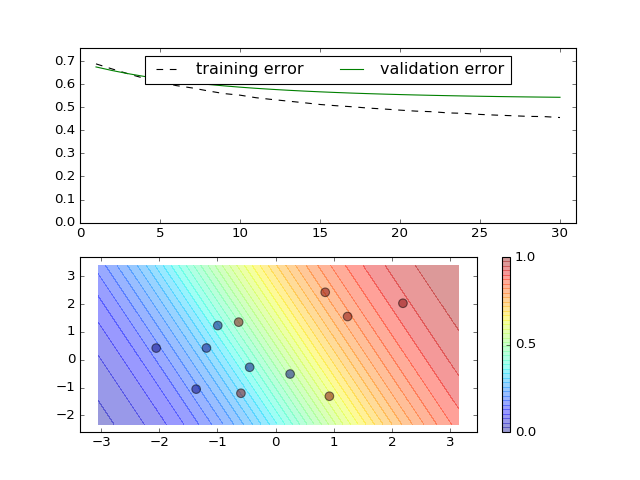

In [18]:
res = train_and_plot(30)

In [19]:
hidden_dim = 5
W1 = parameter(shape=(input_dim, hidden_dim),init=cntk.uniform(1))
b1 = parameter(shape=(hidden_dim),init=cntk.uniform(1))
y = cntk.sigmoid(times(features,W1)+b1)
W2 = parameter(shape=(hidden_dim, output_dim),init=cntk.uniform(1))
b2 = parameter(shape=(output_dim),init=cntk.uniform(1))
z = times(y,W2)+b2
loss = cntk.cross_entropy_with_softmax(z, label)
eval_error = cntk.classification_error(z, label)

#pp=cntk.logging.ProgressPrinter()

learning_rate = 0.2
learner = sgd(z.parameters, lr=cntk.learning_rate_schedule(learning_rate,cntk.UnitType.minibatch))
trainer = Trainer(z, (loss, eval_error), [learner])

## Многослойная модель

  * Можем описывать сложные графы вычислений
  * Нельзя забывать про передаточную функцию (мы использовали `sigmoid`)
  * К последнему слою передаточная функция `softmax` добавляется автоматически
  * Надо подумать про первоначальную активацию весов (`init=uniform`)

<IPython.core.display.Javascript object>


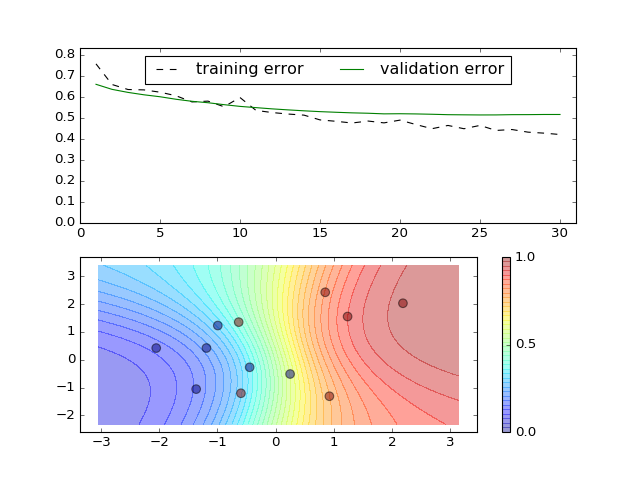

In [20]:
res = train_and_plot(30)

## Определение модели в функциональном стиле

  * Модель обычно состоит из множества последовательно-применяемых слоёв
  * В глубоком обучении количество слоёв может быть весьма большим (100+)
  * Для описания удобно использовать функции комбинирования слоёв
  * Попробуем другую передаточную функцию (`relu`)

In [21]:
from cntk.layers import *
z = Sequential([
    Dense(10,init=glorot_uniform(),activation=relu),
    Dense(output_dim,init=glorot_uniform(),activation=None)
])(features)
loss = cntk.cross_entropy_with_softmax(z, label)
eval_error = cntk.classification_error(z, label)

#pp=cntk.logging.ProgressPrinter()

learning_rate = 0.05
learner = sgd(z.parameters, lr=cntk.learning_rate_schedule(learning_rate,cntk.UnitType.minibatch))
trainer = Trainer(z, (loss, eval_error), [learner])

<IPython.core.display.Javascript object>


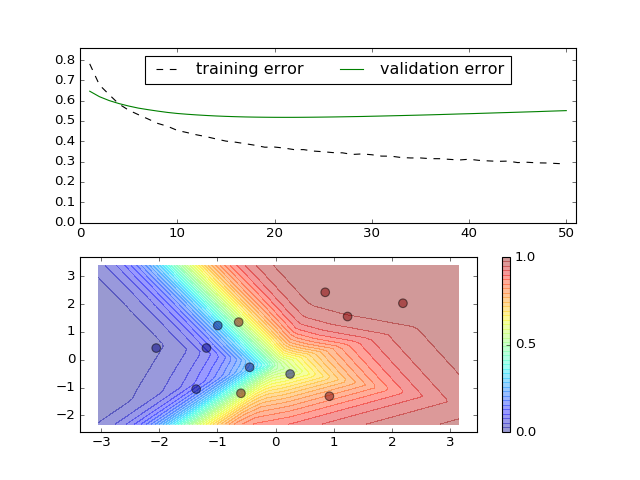

In [22]:
res = train_and_plot(50)

## Важное замечание

Простая линейная модель 
* высокий training loss - "недообучение", выразительности модели не хватает, чтобы разделить данные
* valiadation loss и training loss примерно совпадают - модель хорошо обобщается

Сложная многослойная модель
* низкий training loss - почти идеально приближает обучающую выборку (но может переобучиться)
* validation loss >> training loss и может возрастать - плохо обобщает данные

## Выводы

* Простые модели с небольшим числом параметров ("low capacity") менее склонные к переобучению
* Более сложные модели (high capacity) могут переобучиться (надо следить за validation error)
* Для более сложных моделей необходимо иметь больше данных
* "bias-variance trade-off" - необходимо достичь компромисса между недообучением и переобучением (обучением на распознавание нерелевантного шума во входных данных)

## Как использовать модель

  * Для предсказаний можно использовать формулу `out = softmax(z)` и `out.eval(...)` для вычисления распределения вероятности на выходе
  * Можно сохранить модель на диск в виде двоичного файла: `out.save_model(...)` и впоследствии загрузить её и использовать для предсказаний
  * Эту же модель можно загрузить из C# SDK, из C++ библиотеки CNTK и т.д.

## Обучение с `cntk.exe`

Обучать нейросети можно и без знания Python, с помощью утилиты командной строки.

  * Готовим входные данные в виде текстовых файлов (или изображений) в специальном формате
  * Описываем архитектуру сети и используемые learner/trainer на специальном языке **BrainScript**
  * Запускаем cntk.exe и тренируем модель
  * Получаем файл модели, который можно затем загрузить из Python API, из C# SDK и т.д.

## Описание сети
```
 BrainScriptNetworkBuilder = [
        LDim = 1 : SDim = 2
        features = Input (SDim)
        labels   = Input (LDim)

        b = Parameter (LDim, 1)
        w = Parameter (LDim, SDim)
        p = Sigmoid (w * features + b)    
    
        lr = Logistic (labels, p)
        err = SquareError (labels, p)

        featureNodes    = (features)
        labelNodes      = (labels)
        criterionNodes  = (lr)
        evaluationNodes = (err)
        outputNodes     = (p)]
```

## Описание оптимизатора и входных данных
```
   SGD = [
        epochSize = 0 # 0 - вся входная выборка
        minibatchSize = 25
        learningRatesPerSample = 0.04
        maxEpochs = 50 ]

    reader = [
        readerType = "CNTKTextFormatReader"
        file = "Train_cntk_text.txt"
        input = [
            features = [
                dim = 2
                format = "dense"
            ]
            labels = [
                dim = 1
                format = "dense" ]]
```

## Возможные операции

  * `train` - обучение сети
  * `test` - запуск на тестовых данных
  * `output` - запись результатов в файл
  * `dumpNode` - сохранение узла сети для последующего использования
  
Подробный пример: [тут](https://github.com/Microsoft/CNTK/blob/master/Tutorials/HelloWorld-LogisticRegression/lr_bs.cntk) (аналогичный разобранному здесь)